In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import re,nltk, string, unicodedata
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 500
df = pd.read_csv("Data/formattedData.csv", sep=";")

In [2]:
dfSntTok = df.dropna()
dfSntTok["Respuesta"] = dfSntTok["Respuesta"].apply(nltk.sent_tokenize)
dfSntTok = dfSntTok[dfSntTok['Respuesta'].apply(len) >= 1].dropna()

arrayExterno = []
def separeSentences(row):
    if type(row['Respuesta']) != str:
        if len(row['Respuesta']) == 1:
            row['Respuesta'] = row['Respuesta'][0]
            return row
        else:
            area = row['Area']
            dimension = row['Dimension']
            for sent in row['Respuesta']:
                tempArray = []
                tempArray.append(area)    
                tempArray.append(dimension)
                tempArray.append(sent)
                arrayExterno.append(tempArray)
            row['Respuesta'] = ""
            return row
    else:
        return row

dfSntTok = dfSntTok.apply(separeSentences, axis = 1).copy()
dfSntTok = pd.concat([dfSntTok,\
           pd.DataFrame(arrayExterno, columns=["Area", "Dimension", "Respuesta"])],ignore_index=True).dropna()

C:\Users\Ricardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
def normalizeText(tokens):
    tokens = tokens.replace(r'_', r'').replace(r'¨¢', r'a').replace(r'¨¦',r'e').replace(r'¨ª', r'i')\
        .replace(r'¨²', r'u').replace(r'¨®', r'o').replace(r'?', r'n').replace(r'á', r'a')\
        .replace(r'é',r'e').replace(r'í', r'i').replace(r'ó', r'o').replace(r'ú', r'u').replace(r'ñ', r'n')\
        .replace('Á', r'A').replace(r'É',r'E').replace(r'Í', r'I').replace(r'Ó', r'O').replace(r'Ú', r'U')\
        .replace(r'Ñ', r'N')
    tokens = re.sub(r'[^\w\s ÑñáéíóúÁÉÍÓÚ]', '', tokens)
    tokens = re.sub('\d','',tokens)
    return tokens.lower()

stop = stopwords.words('spanish')
def removeStopWords(tokens, stopword):
    new_ = []
    for token in tokens:
        if token not in stopword and token not in ['etc']:
            new_.append(token)
    return new_

dfNorm = dfSntTok.copy()
dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(normalizeText)\
                                         .apply(nltk.word_tokenize)\
                                         .apply(removeStopWords, stopword = stop)


In [4]:
lemmaDiccionario = {}
with open('Herramientas/lemma.txt', 'rb') as fichero:
    datos = (fichero.read().decode('utf8').replace(u'\r', u'').split(u'\n'))
    datos = ([avance.split(u'\t') for avance in datos])
for avance in datos:
   if len(avance) >1:
      lemmaDiccionario[avance[1]] = avance[0]
        
def lemmatize(word):
   return lemmaDiccionario.get(word, word + u'')
   
def lemmatize_words(words):
    new_words = []
    for palabra in words:
        new_word = lemmatize(palabra)
        new_words.append(new_word)
    return new_words

dfNorm = dfNorm[dfNorm['Respuesta'].map(len) > 3]
dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(lemmatize_words).apply(lambda x: x if len(x) < 10 else x[:10])
dfNorm["Respuesta"].apply(len).describe()

count    165450.000000
mean     6.573460     
std      2.213859     
min      4.000000     
25%      5.000000     
50%      6.000000     
75%      9.000000     
max      10.000000    
Name: Respuesta, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1ba7c143848>,
 'caps': [<matplotlib.lines.Line2D at 0x1ba7c143708>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ba7c1403c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1ba7c13b1c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ba7c13b108>],
 'means': []}

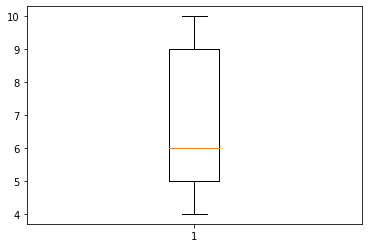

In [5]:
plt.subplots()
dataToPlot = [dfNorm["Respuesta"].apply(len)]
plt.boxplot(dataToPlot)

In [6]:
max_quantity = max(dfNorm.groupby(['Area','Dimension']).count().Respuesta)
array_groups_to_remove = []
for name, group in dfNorm.groupby(['Area','Dimension']):
    if len(group) <= max_quantity/10:
        array_groups_to_remove.append(name)

dfNorm = dfNorm.apply(lambda x, arr_rem: None if (x['Area'],x['Dimension']) in arr_rem else x, axis = 1\
                      , arr_rem = array_groups_to_remove).dropna()

In [7]:
dfNorm.groupby(['Area','Dimension']).count().Respuesta

Area                  Dimension                   
Confianza General     Confianza General               11901
Gobierno Corporativo  Anti-corrupción                 7004 
                      Integridad                      7186 
Medio Ambiente        Ambiental                       2137 
                      Cultura Ambiental               10875
Social Externo        Calidad                         6744 
                      Cliente                         5811 
                      Comunicación                    3195 
                      Comunidad                       4939 
                      Educación                       1928 
                      Imagen                          6414 
                      Infraestructura                 2055 
                      Operación                       2079 
                      Proveedores                     2078 
                      Reclamos                        5865 
                      Recompra                   

In [8]:
dfNorm.to_csv("Data/Flujo1.csv", sep=";", index=False)

In [9]:
Stemmer_spanish = SnowballStemmer('spanish')
def stemWordsArray(tokens, stemmer):
    new_ = []
    for token in tokens:
        new_.append(stemmer.stem(token))
    return new_

dfStemmer = dfNorm.copy()
dfStemmer['Respuesta'] = dfStemmer['Respuesta'].apply(stemWordsArray, stemmer = Stemmer_spanish)
dfStemmer.to_csv("Data/Flujo2.csv", sep=";", index=False)